In [29]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import re
import string
import matplotlib.pyplot as plt

In [3]:
import os

data_folder = '../data'  
presidents = ['teddy', 'washington', 'adams', 'jefferson', 'madison', 'lincoln', 'FDR']

data = []

# Loop through each president folder and read the text files
for president in presidents:
    president_folder = os.path.join(data_folder, president)  
    for filename in os.listdir(president_folder):
        if filename.endswith('.txt'):  
            file_path = os.path.join(president_folder, filename)
            with open(file_path, 'r', encoding='utf-8') as file:
                text = file.read()
                data.append((text, president)) 

print(f"Total examples: {len(data)}")


Total examples: 224


In [4]:
file_counts = {}
word_counts = {}

for president in presidents:
    president_folder = os.path.join(data_folder, president)  
    file_counts[president] = 0
    word_counts[president] = 0

    for filename in os.listdir(president_folder):
        if filename.endswith('.txt'):
            file_counts[president] += 1

            file_path = os.path.join(president_folder, filename)
            with open(file_path, 'r', encoding='utf-8') as file:
                text = file.read()
                word_counts[president] += len(text.split())

print("\nNumber of files per president:")
for president, count in file_counts.items():
    print(f"{president}: {count}")

print("\nNumber of words per president:")
for president, count in word_counts.items():
    print(f"{president}: {count}")



Number of files per president:
teddy: 23
washington: 29
adams: 16
jefferson: 56
madison: 29
lincoln: 43
FDR: 28

Number of words per president:
teddy: 47453
washington: 29253
adams: 15552
jefferson: 171449
madison: 65994
lincoln: 50596
FDR: 55354


In [5]:
def clean_text(text):
    text = re.sub(f"[{string.punctuation}]", "", text)
    text = ' '.join(text.split())
    text = text.lower()
    return text

In [6]:
texts, labels = zip(*data)  
cleaned_texts = [clean_text(text) for text in texts]

# Tokenizing the data

In [7]:
tokenizer = Tokenizer(num_words=10000)  
tokenizer.fit_on_texts(cleaned_texts)

X_seq = tokenizer.texts_to_sequences(cleaned_texts)

max_length = 200  
X_pad = pad_sequences(X_seq, maxlen=max_length, padding='post', truncating='post')

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(labels)  

X_train, X_test, y_train, y_test = train_test_split(X_pad, y_encoded, test_size=0.2, random_state=42)

print(f"Training data: {len(X_train)} examples")
print(f"Testing data: {len(X_test)} examples")


Training data: 179 examples
Testing data: 45 examples


# Building the Tensorflow deep learning model

In [16]:
model = Sequential()

vocab_size = len(tokenizer.word_index) + 1
model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=max_length))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(len(presidents), activation='softmax'))  

model.compile(loss='sparse_categorical_crossentropy', 
              optimizer='adam',
              metrics=['accuracy'])


dummy_input = tf.random.uniform((1, max_length), minval=0, maxval=vocab_size, dtype=tf.int32)

model(dummy_input)
model.summary()

/Users/danchizik/Desktop/president-chatbot/myenv/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)         │ (1, 200, 128)          │     2,639,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (1, 100)               │        91,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (1, 7)                 │           707 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,731,411 (10.42 MB)

 Trainable params: 2,731,411 (10.42 MB)

 Non-trainable params: 0 (0.00 B)

# Training the model

In [17]:
history = model.fit(X_train, y_train,
                    epochs=5, 
                    batch_size=32,  
                    validation_data=(X_test, y_test))  

Epoch 1/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 251ms/step - accuracy: 0.1738 - loss: 1.9448 - val_accuracy: 0.3333 - val_loss: 1.9300
Epoch 2/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 207ms/step - accuracy: 0.3571 - loss: 1.9157 - val_accuracy: 0.3556 - val_loss: 1.9009
Epoch 3/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step - accuracy: 0.3098 - loss: 1.8698 - val_accuracy: 0.3556 - val_loss: 1.8111
Epoch 4/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 295ms/step - accuracy: 0.2931 - loss: 1.8015 - val_accuracy: 0.3556 - val_loss: 1.8471
Epoch 5/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 224ms/step - accuracy: 0.2844 - loss: 1.7592 - val_accuracy: 0.3556 - val_loss: 1.8533


# Evaluating accuracy

In [18]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc}")


2/2 - 0s - 45ms/step - accuracy: 0.3556 - loss: 1.8533
Test accuracy: 0.35555556416511536


# Matplotlib to visualize validation loss and accuracy

### 1. Accuracy

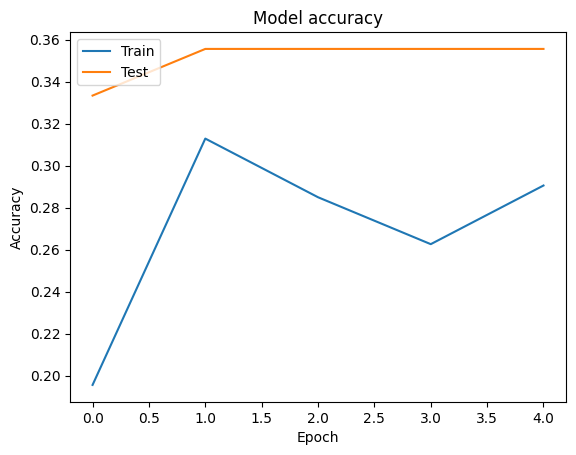

In [21]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### 2. Loss

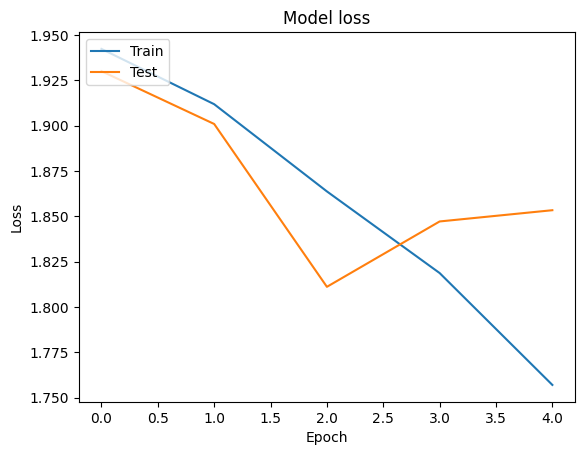

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### Results: accuracy: 0.3556  ; loss: 1.8533 ; Test accuracy: 0.35555556416511536


# Trial #2: Improving the Model

### Using early stopping (prevents overfitting)

In [51]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

In [32]:
max_length = 2000
vocab_size = len(tokenizer.word_index) + 1 
embedding_dim = 256 
lstm_units = 200 
dropout_rate = 0.3  
recurrent_dropout_rate = 0.3  
epochs = 20  
batch_size = 32 
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Building the model

In [33]:
model = Sequential()

model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))

model.add(Bidirectional(LSTM(lstm_units, dropout=dropout_rate, recurrent_dropout=recurrent_dropout_rate)))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))  


model.add(Dense(len(presidents), activation='softmax'))  

# Compiling the model

In [34]:
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=Adam(learning_rate=0.0005),  
              metrics=['accuracy'])
dummy_input = tf.random.uniform((1, max_length), minval=0, maxval=vocab_size, dtype=tf.int32)
model(dummy_input)

model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_11 (Embedding)        │ (1, 2000, 256)         │     5,278,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (1, 400)               │       731,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (1, 256)               │       102,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (1, 256)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (1, 7)                 │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,113,863 (23.32 MB)

 Trainable params: 6,113,863 (23.32 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
history = model.fit(X_train, y_train, 
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_split=0.2, 
                    callbacks=[early_stopping])

Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 926ms/step - accuracy: 0.1177 - loss: 1.9470 - val_accuracy: 0.3889 - val_loss: 1.9300
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 856ms/step - accuracy: 0.3616 - loss: 1.9283 - val_accuracy: 0.5278 - val_loss: 1.9123
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 865ms/step - accuracy: 0.4126 - loss: 1.9112 - val_accuracy: 0.5000 - val_loss: 1.8896
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 837ms/step - accuracy: 0.5052 - loss: 1.8766 - val_accuracy: 0.5278 - val_loss: 1.8530
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 824ms/step - accuracy: 0.4512 - loss: 1.8409 - val_accuracy: 0.5278 - val_loss: 1.7952
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 879ms/step - accuracy: 0.4594 - loss: 1.7784 - val_accuracy: 0.5000 - val_loss: 1.7028
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.4890 - loss: 1.6530 - val_accuracy: 0.4444 - val_loss: 1.6192
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.5051 - loss: 1.5668 - val_accuracy: 0.4722 - val_loss: 1.436

In [36]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)  
print(f'Test accuracy: {test_accuracy}')

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - accuracy: 0.4762 - loss: 1.5269
Test accuracy: 0.5111111402511597


## Results: 51% test accuracy

# Attempt #3: Using regularization and balancing classes

In [37]:
from tensorflow.keras.layers import GRU, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [38]:
model3 = Sequential()

model3.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))

model3.add(Bidirectional(GRU(300, dropout=dropout_rate, recurrent_dropout=recurrent_dropout_rate)))
model3.add(BatchNormalization())  # Add batch normalization

model3.add(Dense(512, activation='relu'))
model3.add(Dropout(0.6))  # Increase dropout

model3.add(Dense(len(presidents), activation='softmax'))  

/Users/danchizik/Desktop/president-chatbot/myenv/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [39]:
model3.compile(loss='sparse_categorical_crossentropy', 
              optimizer=Adam(learning_rate=0.0005),  
              metrics=['accuracy'])

In [40]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=2, 
                              min_lr=0.00001)

In [41]:
history = model3.fit(X_train, y_train, 
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_split=0.2, 
                    callbacks=[early_stopping, reduce_lr])


Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.1746 - loss: 2.0083 - val_accuracy: 0.5278 - val_loss: 1.9260 - learning_rate: 5.0000e-04
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.4983 - loss: 1.4865 - val_accuracy: 0.4444 - val_loss: 1.9102 - learning_rate: 5.0000e-04
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.6140 - loss: 1.1182 - val_accuracy: 0.4722 - val_loss: 1.8945 - learning_rate: 5.0000e-04
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.6609 - loss: 1.0111 - val_accuracy: 0.5000 - val_loss: 1.8798 - learning_rate: 5.0000e-04
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.7593 - loss: 0.7314 - val_accuracy: 0.5833 - val_loss: 1.8652 - learning_rate: 5.0000e-04
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.8090 - loss: 0.6135 - val_accuracy: 0.5556 - val_loss: 1.8514 - learning_rate: 5.0000e-04
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.8657 - loss: 0.5352 - val_accura

In [42]:
test_loss, test_accuracy = model3.evaluate(X_test, y_test)  
print(f'Test accuracy: {test_accuracy}')

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 261ms/step - accuracy: 0.5326 - loss: 1.7619
Test accuracy: 0.5333333611488342


# Using a pre-trained Bert model

In [45]:
from transformers import TFBertForSequenceClassification, BertTokenizer

In [46]:
tokenizerBert = BertTokenizer.from_pretrained('bert-base-uncased')
modelBert = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(presidents))

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [49]:
inputs = tokenizerBert(cleaned_texts, padding=True, truncation=True, return_tensors="tf")
outputs = modelBert(inputs)

KeyboardInterrupt: 

In [55]:
modelBert.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
historyBert = modelBert.fit(X_train, y_train, epochs=5, batch_size=32)

Epoch 1/5
6/6 [==============================] - 122s 19s/step - loss: 7.8841 - accuracy: 0.1844
Epoch 2/5
6/6 [==============================] - 139s 23s/step - loss: 9.2895 - accuracy: 0.1397
Epoch 3/5
6/6 [==============================] - 131s 21s/step - loss: 8.5318 - accuracy: 0.1397
Epoch 4/5
6/6 [==============================] - 158s 27s/step - loss: 8.7483 - accuracy: 0.1285
Epoch 5/5
6/6 [==============================] - 127s 20s/step - loss: 8.5878 - accuracy: 0.1285


KeyError: 'val_loss'

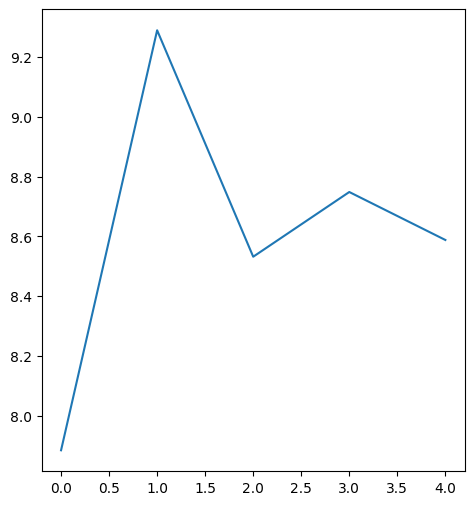

In [56]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(historyBert.history['loss'], label='Training Loss')
plt.plot(historyBert.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

KeyError: 'val_accuracy'

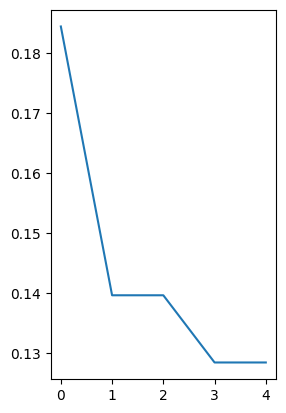

In [57]:
plt.subplot(1, 2, 2)
plt.plot(historyBert.history['accuracy'], label='Training Accuracy')
plt.plot(historyBert.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [ ]:
plt.tight_layout()
plt.show()